In [51]:
import tensorflow_quantum as tfq
import cirq
import numpy as np
from math import prod
import matplotlib.pyplot as plt

In [196]:
def XY_hamiltonian(n, gs, ls):
    qs = [cirq.GridQubit(0, i) for i in range(n)]
    ham = cirq.PauliSum()
    for i in range(n - 1):
        ham -= gs[i] * cirq.X(qs[i]) * cirq.X(qs[i + 1])
        ham -= gs[i] * cirq.Y(qs[i]) * cirq.Y(qs[i + 1])
    for i in range(n):
        ham -= ls[i] * cirq.Z(qs[i])
    return ham

def XXZ_chain(n):
    qs = [cirq.GridQubit(0, i) for i in range(n)]
    ham = cirq.PauliSum()
    for i in range(n - 1):
        ham += cirq.X(qs[i]) * cirq.X(qs[i + 1])
        ham += cirq.Y(qs[i]) * cirq.Y(qs[i + 1])
        ham += cirq.Z(qs[i]) * cirq.Z(qs[i + 1])
    return ham

def TFI_chain(n, gs):
    qs = [cirq.GridQubit(0, i) for i in range(n)]
    ham = cirq.PauliSum()
    for i in range(n - 1):
        ham -= cirq.Z(qs[i]) * cirq.Z(qs[i + 1])
    for i in range(n):
        ham -= gs[i] * cirq.X(qs[i])
    return ham

In [197]:
def circuit_exp(circuits, ops):
    exp = tfq.layers.Expectation()
    return exp(circuits, symbol_names=[], symbol_values=[[] for _ in circuits], operators=ops).numpy()

In [278]:
def trotter_step(hamil, t, reverse=False):
    if reverse:        
        return cirq.Circuit(reversed([tfq.util.exponential([t * i]) for i in hamil]))
    return cirq.Circuit([tfq.util.exponential([t * i]) for i in hamil])

In [279]:
def lie_trotter(hamil, t, reps):
    cir = cirq.Circuit()
    for i in range(reps):
        cir += trotter_step(hamil, t/reps)
    return cir

def second_order_suzuki_trotter(hamil, t, reps):
    cir = cirq.Circuit()
    for i in range(reps):
        cir += trotter_step(hamil, t/(2 * reps))
        cir += trotter_step(hamil, t/(2 * reps), True)
    return cir

def suzuki_trotter(hamil, t, order, reps):
    if order == 2:
        return second_order_suzuki_trotter(hamil, t, reps)
    s_k = (4 - 4**(1 / (order - 1)))**(-1)
    c = cirq.Circuit()
    sub_2 = suzuki_trotter(hamil, s_k * t, order - 2, reps)
    c += sub_2
    c += sub_2
    c += suzuki_trotter(hamil, (1 - 4 * s_k) * t, order - 2, reps)
    c += sub_2
    c += sub_2
    return c

In [349]:
n = 4
qs = [cirq.GridQubit(0, i) for i in range(n)]
ops = prod([cirq.Z(i) for i in qs])
mag = sum([cirq.Z(i) for i in qs])

In [398]:
ham = TFI_chain(n, [1.0] * n)
times1 = np.linspace(0.01, 2, 20)

In [343]:
circuits_l_small = [lie_trotter(ham, float(i), 1) for i in times]
circuits_l_large = [lie_trotter(ham, float(i), 10) for i in times]
circuits_l_mid = [lie_trotter(ham, float(i), 3) for i in times]
circuits_s_small = [suzuki_trotter(ham, float(i), 2, 1) for i in times]
circuits_s_large = [suzuki_trotter(ham, float(i), 6, 1) for i in times]
circuits_s_small_rep = [suzuki_trotter(ham, float(i), 2, 10) for i in times]
circuits_s_large_rep = [suzuki_trotter(ham, float(i), 6, 10) for i in times]

In [344]:
z_exp_l_small = circuit_exp(circuits_l_small, ops)
z_exp_l_large = circuit_exp(circuits_l_large, ops)
z_exp_l_mid = circuit_exp(circuits_l_mid, ops)
z_exp_s_large = circuit_exp(circuits_s_large, ops)
z_exp_s_small = circuit_exp(circuits_s_small, ops)
z_exp_s_large_rep = circuit_exp(circuits_s_large_rep, ops)
z_exp_s_small_rep = circuit_exp(circuits_s_small_rep, ops)

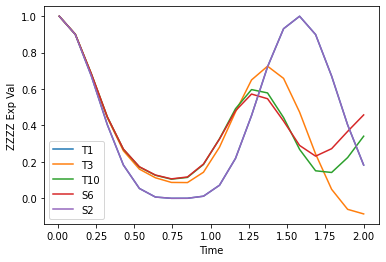

In [406]:
plt.plot(times1, z_exp_l_small, label='T1')
plt.plot(times1, z_exp_l_mid, label='T3')
plt.plot(times1, z_exp_l_large, label='T10')
plt.plot(times1, z_exp_s_large, label='S6')
plt.plot(times1, z_exp_s_small, label='S2')

plt.xlabel("Time")
plt.ylabel("ZZZZ Exp Val")
plt.legend()
plt.show()

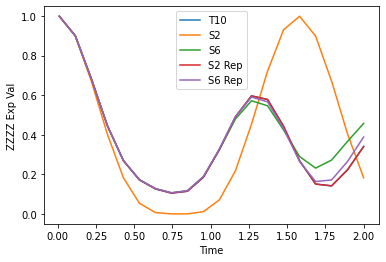

In [408]:
plt.plot(times1, z_exp_l_large, label='T10')
plt.plot(times1, z_exp_s_small, label='S2')
plt.plot(times1, z_exp_s_large, label='S6')
plt.plot(times1, z_exp_s_small_rep, label='S2 Rep')
plt.plot(times1, z_exp_s_large_rep, label='S6 Rep')

plt.xlabel("Time")
plt.ylabel("ZZZZ Exp Val")
plt.legend()
plt.show()

In [433]:
n = 3

qs = [cirq.GridQubit(0, i) for i in range(n)]
ops = prod([cirq.Z(i) for i in qs])
mag = sum([cirq.Z(i) for i in qs])

ham = TFI_chain(n, [1.0] * n)

op_list = [ops, mag, ham]

In [434]:
times = np.linspace(0.01, 6, 100)
circuits_small = [lie_trotter(ham, float(i), 1) for i in times]
circuits_large = [lie_trotter(ham, float(i), 10) for i in times]
circuits_mid = [lie_trotter(ham, float(i), 3) for i in times]

z_exp_small = circuit_exp(circuits_small, op_list)
z_exp_large = circuit_exp(circuits_large, op_list)
z_exp_mid = circuit_exp(circuits_mid, op_list)

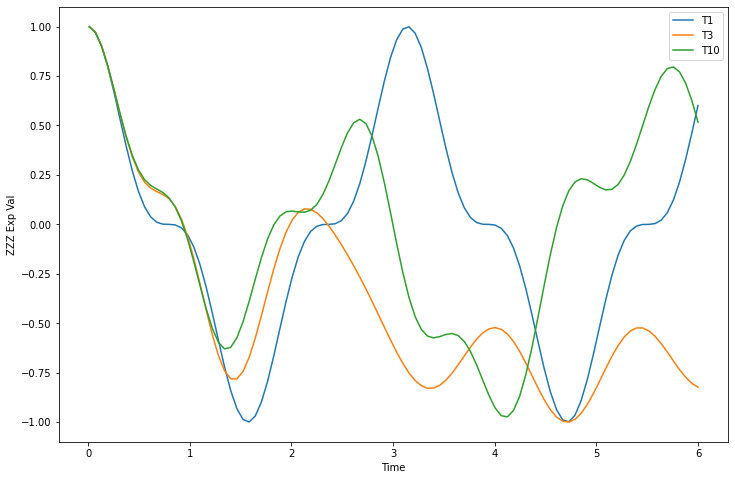

In [440]:
fig = plt.figure(figsize=(12, 8))
plt.plot(times, z_exp_small[:,0], label='T1')
plt.plot(times, z_exp_mid[:,0], label='T3')
plt.plot(times, z_exp_large[:,0], label='T10')

plt.xlabel("Time")
plt.ylabel("ZZZ Exp Val")
plt.legend()
plt.show()

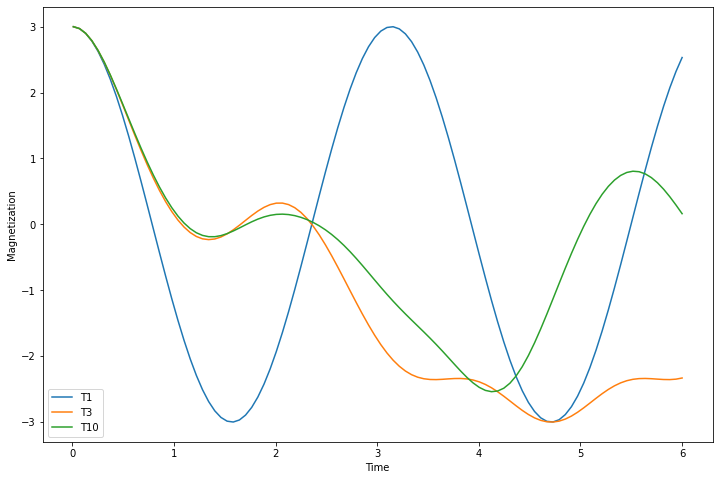

In [442]:
fig = plt.figure(figsize=(12, 8))
plt.plot(times, z_exp_small[:,1], label='T1')
plt.plot(times, z_exp_mid[:,1], label='T3')
plt.plot(times, z_exp_large[:,1], label='T10')

plt.xlabel("Time")
plt.ylabel("Magnetization")
plt.legend()
plt.show()

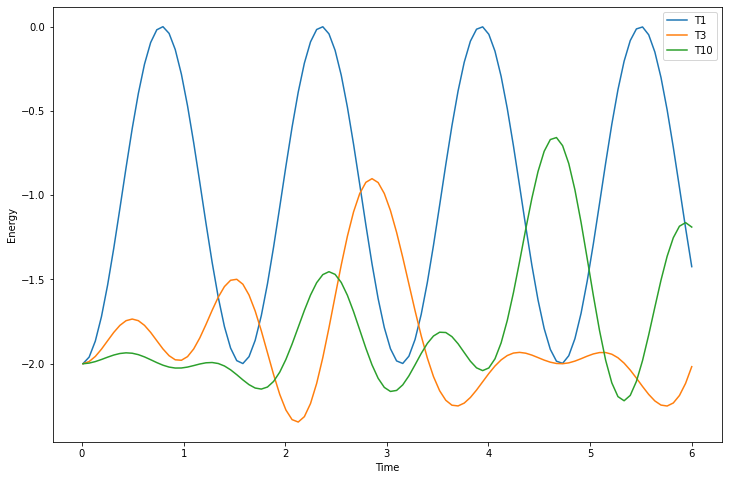

In [443]:
fig = plt.figure(figsize=(12, 8))
plt.plot(times, z_exp_small[:,2], label='T1')
plt.plot(times, z_exp_mid[:,2], label='T3')
plt.plot(times, z_exp_large[:,2], label='T10')

plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.show()